In [8]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications.nasnet import NASNetMobile
from keras.utils import multi_gpu_model
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D
from keras import backend as K
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numpy as np

from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)

### Prepare Dataset

In [2]:
TRAIN_DIR = "../../data/SantaCruzIsland_Labeled_5Class"
VALID_DIR = "../../data/SantaCruzIsland_Validation_5Class"
BATCH_SIZE = 8
NUM_EPOCHS = 1
WIDTH = 1920
HEIGHT = 1080
num_train_images = 100
num_valid_images = 10

num_birds = 127
num_empty = 249
num_fox = 11
num_humans = 32
num_rodents = 251

total_num = [num_birds, num_empty, num_fox, num_humans, num_rodents]
reciprocal = [1/x for x in total_num]
class_weights = [ x / sum(reciprocal) for x in reciprocal]
# print (class_weights)

# The total size of training dataset
totakl_train_size = num_train_images * NUM_EPOCHS

In [3]:
train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=90, \
                                         horizontal_flip=True, vertical_flip=True)
train_generator = train_datagen.flow_from_directory(TRAIN_DIR, target_size=(WIDTH, HEIGHT), batch_size = BATCH_SIZE)

Found 666 images belonging to 5 classes.


In [4]:
valid_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=90, 
                                         horizontal_flip=True, vertical_flip=True)
valid_generator = valid_datagen.flow_from_directory(VALID_DIR, target_size=(WIDTH, HEIGHT), batch_size = BATCH_SIZE)

Found 15 images belonging to 5 classes.


### Create Model

In [5]:
resnet50_model = ResNet50(input_shape=(WIDTH, HEIGHT, 3), weights='imagenet', include_top=False)

Instructions for updating:
Colocations handled automatically by placer.


/Users/michaelzhang/miniconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [8]:
nasnet_mobile = NASNetMobile(include_top=False, weights='imagenet', pooling='max')

In [6]:
def build_model(base_model, dropout, fc_layers, num_classes):

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # let's add fully-connected layers
    # Every FC layer has a dropout probability
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)

    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)    
    
    return model

In [14]:
parallel_model = multi_gpu_model(resnet50_model)

ValueError: For multi-gpu usage to be effective, call `multi_gpu_model` with `gpus >= 2`. Received: `gpus=0`

In [7]:
class_list = ["Birds", "Empty", "Fox", "Humans", "Rodents"]
FC_LAYERS = [1024, 1024]
dropout = 0.5



layered_model = build_model(resnet50_model, dropout=dropout, fc_layers=FC_LAYERS, num_classes=len(class_list))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Train the model

In [8]:
def train_model(model, model_name, train_data_gen, valid_data_gen, class_weight):

    # create adam optimizer with learning rate
    adam = Adam(lr=0.00001)

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint("../checkpoints/{0}_model_weights.h5".format(model_name), monitor=["acc"], verbose=1, mode='max')
    
    history = model.fit_generator(generator=train_data_gen, epochs = NUM_EPOCHS, workers=8, 
                                  steps_per_epoch=num_train_images // BATCH_SIZE, shuffle=True, callbacks=[checkpoint],
                                  validation_data=valid_data_gen, validation_steps = num_valid_images // BATCH_SIZE,
                                  class_weight = class_weight)

    return history, model


In [138]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'b.')
    plt.plot(epochs, val_acc, 'r-')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'b.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()
    
    plt.savefig('training_history.png')
    

In [9]:
history, trained_model = train_model(layered_model, "ResNet50", train_generator, valid_generator, class_weights)


Instructions for updating:
Use tf.cast instead.
Epoch 1/1


KeyboardInterrupt: 

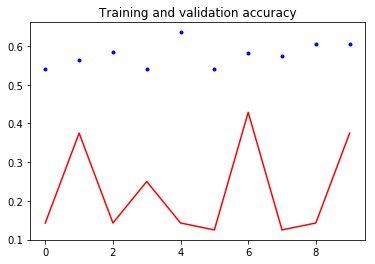

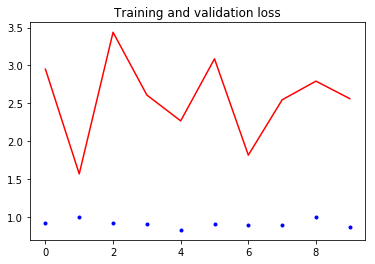

<Figure size 432x288 with 0 Axes>

In [98]:
plot_training(history)

### Make inference

In [101]:
img = image.load_img(path="../../data/SantaCruzIsland_Labeled_5Class/Empty/IMG_0047.JPG", target_size=(1920, 1080))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [102]:
layered_model.load_weights("../checkpoints/{0}_model_weights.h5".format("ResNet50"))
y_prob = layered_model.predict(x)
index = y_prob.argmax()
print ("Predictde : {0}".format(class_list[index]) + " Probability : {0}".format(y_prob[0][index]))

Predictde : Rodents Probability : 0.5146294832229614
